# End-to-end ML Notebook
This notebook's purpose is to show how one might:

1. Construct an ML pipeline.
2. Run it.
3. Get intermediate outputs.
4. Split things up into separate computation tasks and materialize various artifacts.

This builds off of the `data-feature-engineering` notebook, and focuses more on composability of flows, and then re-running inference with overrides. So we will duplicate part of the notebook to ensure it is self-contained, we will skip over the parts that the other notebook went over and assume familiarity with that was shown there.

Note: the inference & data set produced by features.py are the same. We leave it as an exercise to the reader to modify the code to split things in a way where they would not be the same.


# Notebook setup


In [38]:
from IPython.display import clear_output

Uncomment and run the cell below if you are in a Google Colab environment. It will:

1. Mount google drive. You will be asked to authenticate and give permissions.
2. Change directory to google drive.
3. Make a directory "hamilton-tutorials"
4. Change directory to it.
5. Clone this repository to your google drive
6. Move your current directory to the example
7. Install requirements.
8. This means that any modifications will be saved, and you won't lose them if you close your browser.

In [39]:
## 1. Mount google drive
# from google.colab import drive
# drive.mount('/content/drive')
## 2. Change directory to google drive.
# %cd /content/drive/MyDrive
## 3. Make a directory "hamilton-tutorials"
# !mkdir hamilton-tutorials
## 4. Change directory to it.
# %cd hamilton-tutorials
## 5. Clone this repository to your google drive
# !git clone https://github.com/DAGWorks-Inc/hamilton-tutorials/
## 6. Move your current directory to the example
# %cd hamilton-tutorials/2023-10-09/titanic_dataset
## 7. Install requirements.
# %pip install -r requirements.txt
# clear_output()  # optionally clear outputs
# To check your current working directory you can type `!pwd` in a cell and run it.

In [40]:
import os
import numpy as np
import pandas as pd
from hamilton import driver, base
from dagworks import driver as dw_driver
from hamilton.function_modifiers import source
from hamilton.io.materialization import to
from IPython.display import display

# Use autoreload to automatically reload our function modules
%load_ext autoreload
%autoreload 1

DAGWORKS_API_KEY = os.environ["DAGWORKS_STAGING_API_KEY"]
DAGWORKS_PROJECT_ID = 3
DAGWORKS_PROJECT_EMAIL = "stefan@dagworks.io"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Code to load data
This module loads the data -- see the `data-feature-engineering` notebook for more explanation.

In [41]:
%%writefile data_loader.py
"""
This module contains our data loading functions.
"""
from typing import List

import pandas as pd
import pandera as pa
from sklearn import datasets

from hamilton.function_modifiers import check_output, config, extract_columns, load_from, source


def _sanitize_columns(df_columns: List[str]) -> List[str]:
    """Renames columns to be valid hamilton names -- and lower cases them.
    :param df_columns: the current column names.
    :return: sanitize column names that work with Hamilton
    """
    return [
        c.strip().replace(".", "_").replace("/", "_per_").replace(" ", "_").lower()
        for c in df_columns
    ]


# schema to validate against
passengers_df_schema = pa.DataFrameSchema(
    {
        "pclass": pa.Column(int, nullable=False),
        # "pclass": pa.Column(float, nullable=False),  # swap this for the above to fail/warn
        "sex": pa.Column(str, nullable=False),
        "age": pa.Column(float, nullable=True),
        "parch": pa.Column(int, nullable=False),
        "sibsp": pa.Column(int, nullable=False),
        "fare": pa.Column(float, nullable=True),
        "embarked": pa.Column(str, nullable=True),
        "name": pa.Column(str, nullable=False),
        "ticket": pa.Column(str, nullable=False),
        "boat": pa.Column(str, nullable=True),
        "body": pa.Column(float, nullable=True),
        "home_dest": pa.Column(str, nullable=True),
        "cabin": pa.Column(str, nullable=True),
        "survived": pa.Column(pa.dtypes.Category, nullable=False),
    },
    strict=True,
)


@config.when(loader="openml")
def raw_passengers_df__openml() -> pd.DataFrame:
    """Pulls data from the web. Only becomes a node in the DAG if `openml` is specified.

    :return: dataframe of data.
    """
    base, targets = datasets.fetch_openml("titanic", parser='auto', version=1, as_frame=True, return_X_y=True)
    df = pd.concat([base, targets], axis=1)
    return df


@config.when(loader="parquet")
@load_from.csv(path=source("titanic_dataset_path"))
def raw_passengers_df__parquet(raw_passengers: pd.DataFrame) -> pd.DataFrame:
    """Pulls data from the web. Only becomes a node in the DAG if `openml` is specified.

    :return: dataframe of data.
    """
    return raw_passengers


@extract_columns("pclass", "sex", "age", "parch", "sibsp", "fare", "embarked", "name", "survived")
@check_output(schema=passengers_df_schema, target_="passengers_df", importance="fail")
def passengers_df(raw_passengers_df: pd.DataFrame) -> pd.DataFrame:
    """Function to take in a raw dataframe, check the output, and then extract columns.

    :param raw_passengers_df: the raw dataset we want to bring in.
    :return:
    """
    raw_passengers_df = raw_passengers_df.dropna(subset=["embarked"])
    raw_passengers_df.columns = _sanitize_columns(raw_passengers_df.columns)
    return raw_passengers_df


def target(survived: pd.Series) -> pd.Series:
    """Just hard coding this mapping that we want survived to be our target.

    :param survived:
    :return:
    """
    target_col = survived.copy()
    target_col.name = "target"
    return target_col


Overwriting data_loader.py


In [42]:
# load the data_loader and setup autoreloading
%aimport data_loader

# Code to featurize the data
This module featurizes the data -- see the `data-feature-engineering` notebook for more explanation.

In [43]:
%%writefile features.py
"""
This is a module that contains our feature transforms.
"""
import pickle
from typing import Set

import pandas as pd

# from sklearn.preprocessing import OneHotEncoder
from sklearn import impute  # import KNNImputer
from sklearn import preprocessing

from hamilton.function_modifiers import check_output, config


def rare_titles() -> Set[str]:
    """Rare titles we've curated"""
    return {
        "Capt",
        "Col",
        "Don",
        "Dona",
        "Dr",
        "Jonkheer",
        "Lady",
        "Major",
        "Mlle",
        "Mme",
        "Ms",
        "Rev",
        "Sir",
        "the Countess",
    }


@check_output(data_type=int)
def family_size(parch: pd.Series, sibsp: pd.Series) -> pd.Series:
    return parch + sibsp


def normalized_name(name: pd.Series) -> pd.Series:
    """I believe this actually gets the honorific, not the name."""
    return name.apply(lambda x: x.split(",")[1].split(".")[0].strip())


def title(normalized_name: pd.Series, rare_titles: Set[str]) -> pd.Series:
    return normalized_name.apply(lambda n: "rare" if n in rare_titles else n)


def is_alone(family_size: pd.Series) -> pd.Series:
    return (family_size == 1).astype(int)


def one_hot_encoder() -> preprocessing.OneHotEncoder:
    return preprocessing.OneHotEncoder(handle_unknown="ignore", sparse=False)


@config.when(model_to_use="create_new")
def fit_categorical_encoder__create_new(
    one_hot_encoder: preprocessing.OneHotEncoder,
    embarked: pd.Series,
    sex: pd.Series,
    pclass: pd.Series,
    title: pd.Series,
    is_alone: pd.Series,
) -> preprocessing.OneHotEncoder:
    cat_df = pd.concat([embarked, sex, pclass, title, is_alone], axis=1)
    cat_df.columns = cat_df.columns.astype(str)
    one_hot_encoder.fit(cat_df)
    return one_hot_encoder


@config.when(model_to_use="use_existing")
def fit_categorical_encoder__use_existing(
    categorical_encoder_path: str,
) -> preprocessing.OneHotEncoder:
    with open(categorical_encoder_path, "rb") as f:
        return pickle.load(f)


def categorical_df(
    fit_categorical_encoder: preprocessing.OneHotEncoder,
    embarked: pd.Series,
    sex: pd.Series,
    pclass: pd.Series,
    title: pd.Series,
    is_alone: pd.Series,
) -> pd.DataFrame:
    """This creates the dataframe of categorical features.

    The number of "features" output depends on the number of categories.

    :param fit_categorical_encoder:
    :param embarked:
    :param sex:
    :param pclass:
    :param title:
    :param is_alone:
    :return:
    """
    cat_df = pd.concat([embarked, sex, pclass, title, is_alone], axis=1)
    cat_df.columns = cat_df.columns.astype(str)
    cat_df = fit_categorical_encoder.transform(cat_df)
    df = pd.DataFrame(cat_df)
    df.index = embarked.index
    df.columns = [f"categorical_{c}" for c in df.columns]
    return df


def knn_imputer(n_neighbors: int = 5) -> impute.KNNImputer:
    return impute.KNNImputer(n_neighbors=n_neighbors)


@config.when(model_to_use="create_new")
def fit_knn_imputer__create_new(
    knn_imputer: impute.KNNImputer,
    age: pd.Series,
    fare: pd.Series,
    family_size: pd.Series,
) -> impute.KNNImputer:
    num_df = pd.concat([age, fare, family_size], axis=1)
    num_df.columns = num_df.columns.astype(str)
    knn_imputer.fit(num_df)
    return knn_imputer


@config.when(model_to_use="use_existing")
def fit_knn_imputer__use_existing(knn_imputer_path: str) -> impute.KNNImputer:
    with open(knn_imputer_path, "rb") as f:
        return pickle.load(f)


def knn_imputed_df(
    fit_knn_imputer: impute.KNNImputer,
    age: pd.Series,
    fare: pd.Series,
    family_size: pd.Series,
) -> pd.DataFrame:
    """This creates the dataframe of KNN imputed numeric features.

    :param fit_knn_imputer:
    :param age:
    :param fare:
    :param family_size:
    :return:
    """
    num_df = pd.concat([age, fare, family_size], axis=1)
    num_df.columns = num_df.columns.astype(str)
    imputed_df = fit_knn_imputer.transform(num_df)
    df = pd.DataFrame(imputed_df)
    df.index = age.index
    df.columns = [f"knn_imputed_{c}" for c in df.columns]
    return df


def robust_scaler() -> preprocessing.RobustScaler:
    return preprocessing.RobustScaler()


@config.when(model_to_use="create_new")
def fit_scaler__create_new(
    robust_scaler: preprocessing.RobustScaler, knn_imputed_df: pd.DataFrame
) -> preprocessing.RobustScaler:
    robust_scaler.fit(knn_imputed_df)
    return robust_scaler


@config.when(model_to_use="use_existing")
def fit_scaler__use_existing(scaler_path: str) -> preprocessing.RobustScaler:
    with open(scaler_path, "rb") as f:
        return pickle.load(f)


def scaled_numeric_df(
    fit_scaler: preprocessing.RobustScaler, knn_imputed_df: pd.DataFrame
) -> pd.DataFrame:
    """This creates the dataframe of scaled numeric features.

    :param fit_scaler:
    :param knn_imputed_df:
    :return:
    """
    num_df = fit_scaler.transform(knn_imputed_df)
    df = pd.DataFrame(num_df)
    df.index = knn_imputed_df.index
    df.columns = [f"scaled_numeric_{c}" for c in df.columns]
    return df


def data_set(
    scaled_numeric_df: pd.DataFrame, categorical_df: pd.DataFrame, target: pd.Series
) -> pd.DataFrame:
    """This function creates our dataset.

    Following what was in the code, this is how the features are stuck together.

    :param scaled_numeric_df:
    :param categorical_df:
    :param target:
    :return:
    """
    return pd.concat([scaled_numeric_df, categorical_df, target], axis=1)


def inference_set(scaled_numeric_df: pd.DataFrame, categorical_df: pd.DataFrame) -> pd.DataFrame:
    """This function creates an inference set.

    :param scaled_numeric_df:
    :param categorical_df:
    :return:
    """
    return pd.concat([scaled_numeric_df, categorical_df], axis=1)


Overwriting features.py


In [44]:
# import for reloading features.py
%aimport features

# Let's write the model fitting code
The following module sets up the model pipeline that fits and the predicts.

It uses `@extract_fields` which given a dictionary of output, makes the values in that dictionary available for downstream consumption.

It also is set up to take in a pre-fit model, instead of creating a new one from a training set. We'll connect this with materialization below.

In [45]:
%%writefile ml_pipeline.py
"""
This is a module that contains our "model fitting and related" transforms.
"""
import pickle
from typing import Dict

import numpy as np
import pandas as pd
from sklearn import base, linear_model, metrics, model_selection

from hamilton.function_modifiers import config, extract_fields


def target_column_name() -> str:
    """What column do we assume in the data set to be the target?"""
    return "target"


def model_classifier(random_state: int) -> base.ClassifierMixin:
    """Creates an unfitted LR model object.

    :param random_state:
    :return:
    """
    lr = linear_model.LogisticRegression(random_state=random_state)
    return lr


@extract_fields({"train_set": pd.DataFrame, "test_set": pd.DataFrame})
def train_test_split(
    data_set: pd.DataFrame, target_column_name: str, test_size: float
) -> Dict[str, pd.DataFrame]:
    """Splits the dataset into train & test.

    :param data_set: the dataset with all features already computed
    :param target: the target column. Used to stratify the training & test sets.
    :param test_size: the size of the test set to produce.
    :return:
    """
    train, test = model_selection.train_test_split(data_set, stratify=data_set[target_column_name], test_size=test_size)
    return {"train_set": train, "test_set": test}


@config.when(model_to_use="create_new")
def fit_model__create_new(
    model_classifier: base.ClassifierMixin, train_set: pd.DataFrame, target_column_name: str
) -> base.ClassifierMixin:
    """Fits a new model.

    :param model_classifier:
    :param train_set:
    :return:
    """
    feature_cols = [c for c in train_set.columns if c != target_column_name]
    model_classifier.fit(train_set[feature_cols], train_set[target_column_name])
    return model_classifier


@config.when(model_to_use="use_existing")
def fit_model__use_existing(model_path: str) -> base.ClassifierMixin:
    with open(model_path, "rb") as f:
        return pickle.load(f)


def y_train_estimation(
    fit_model: base.ClassifierMixin, train_set: pd.DataFrame, target_column_name: str
) -> np.ndarray:
    feature_cols = [c for c in train_set.columns if c != target_column_name]
    return fit_model.predict(train_set[feature_cols])


def y_train(train_set: pd.DataFrame, target_column_name: str) -> pd.Series:
    return train_set[target_column_name]


def cm_train(y_train: pd.Series, y_train_estimation: np.ndarray) -> np.ndarray:
    return metrics.confusion_matrix(y_train, y_train_estimation)


def y_test_estimation(
    fit_model: base.ClassifierMixin, test_set: pd.DataFrame, target_column_name: str
) -> np.ndarray:
    feature_cols = [c for c in test_set.columns if c != target_column_name]
    return fit_model.predict(test_set[feature_cols])


def y_test(test_set: pd.DataFrame, target_column_name: str) -> pd.Series:
    return test_set[target_column_name]


def cm_test(y_test: pd.Series, y_test_estimation: np.ndarray) -> np.ndarray:
    return metrics.confusion_matrix(y_test, y_test_estimation)


def y_test_accuracy(y_test: pd.Series, y_test_estimation: np.ndarray) -> float:
    # metrics.accuracy_score(y_true, y_pred)
    # raise ValueError("hi")
    return metrics.accuracy_score(y_test, y_test_estimation)


def model_predict(fit_model: base.ClassifierMixin, inference_set: pd.DataFrame) -> np.ndarray:
    return fit_model.predict(inference_set)


Overwriting ml_pipeline.py


In [46]:
%aimport ml_pipeline

# Let's see the model pipeline module by itself


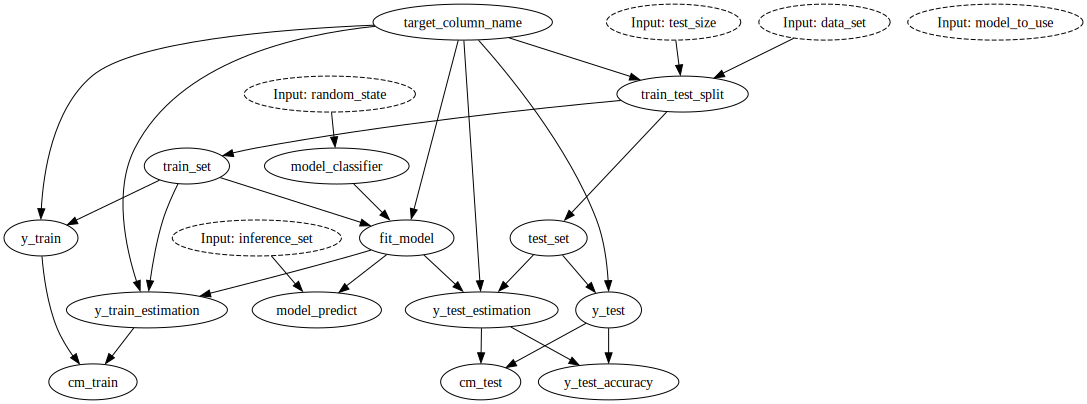

In [47]:
config = {"model_to_use": "create_new"}  # assumes we are creating a new model 
dr = (
        driver.Builder()
        .with_modules(ml_pipeline)
        .with_config(config)
        .build()
    )
dr.display_all_functions()

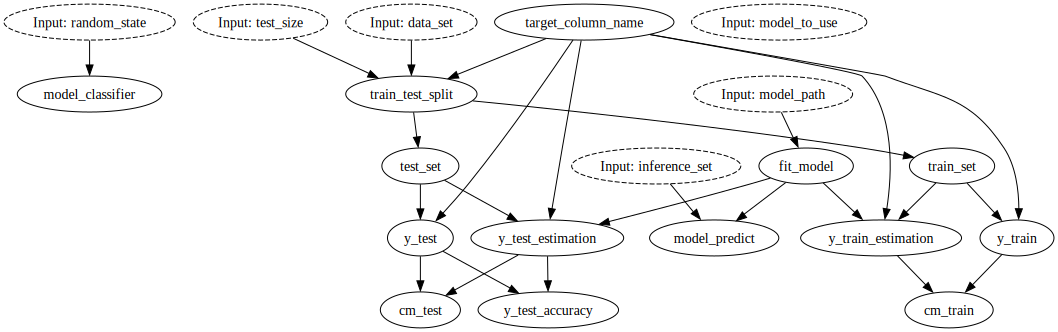

In [48]:
config = {"model_to_use": "use_existing"}  # assumes we are loading a new model from a file
dr = (
        driver.Builder()
        .with_modules(ml_pipeline)
        .with_config(config)
        .build()
    )
dr.display_all_functions()

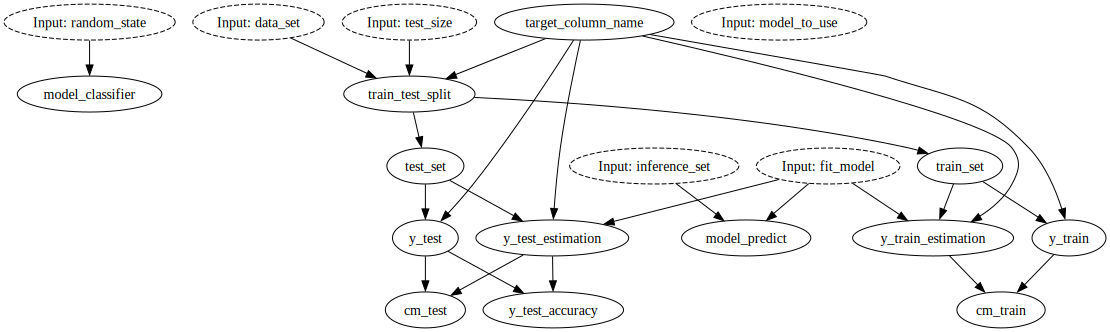

In [49]:
config = {"model_to_use": "manual"}  # this will assume we pass in the fit_model via inputs
dr = (
        driver.Builder()
        .with_modules(ml_pipeline)
        .with_config(config)
        .build()
    )
dr.display_all_functions()

# Let's actually run it

Step 1. Visualize it!

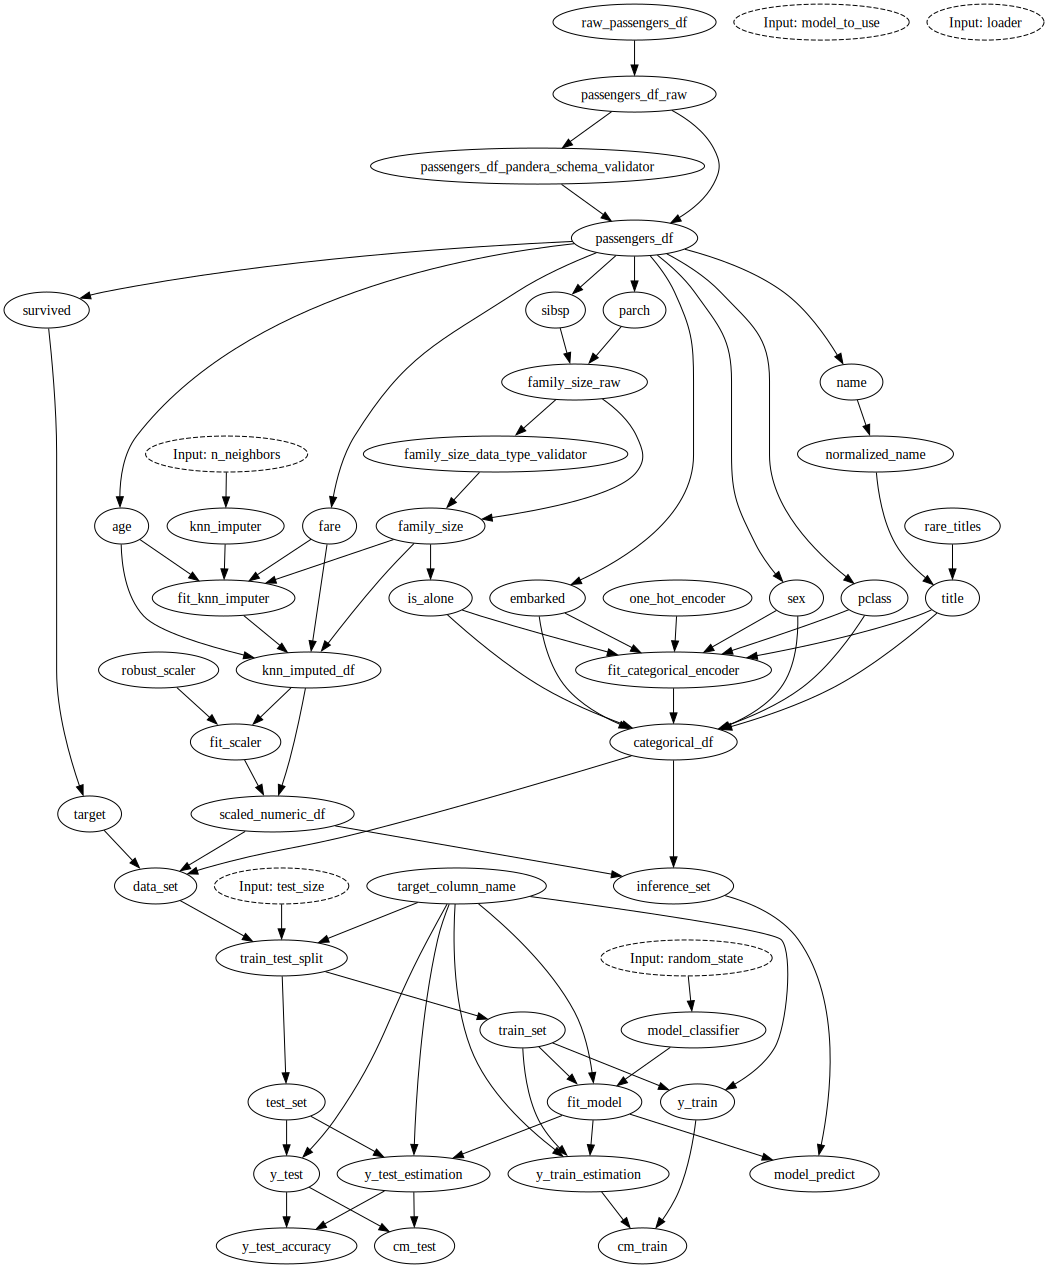

In [50]:
config = {"model_to_use": "create_new", "loader": "openml"}  # assumes we are creating a new model 
dr = (
        driver.Builder()
        .with_modules(data_loader, features, ml_pipeline)
        .with_config(config)
        .build()
    )
dr.display_all_functions()

# Let's run it!

Step 2. Run it

Let's get the evals, and the output of prediction

In [51]:
outputs = ["cm_train", "cm_test", "y_test_accuracy"]
_, results = dr.materialize(
    additional_vars=outputs, 
    inputs={"random_state": 1, "test_size": 0.2})
print(results.keys())
print(results['cm_train'])
print(results['cm_test'])
print(results['y_test_accuracy'])

dict_keys(['cm_train', 'cm_test', 'y_test_accuracy'])
[[557  90]
 [109 289]]
[[148  14]
 [ 27  73]]
0.8435114503816794


/Users/stefankrawczyk/.pyenv/versions/3.9.13/envs/temp-py39/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Let's connect it to DAGWorks

In [52]:
# instantiate the driver
dw_dr = dw_driver.Driver(
   config,
   data_loader, features, ml_pipeline,
   project_id=DAGWORKS_PROJECT_ID,
   api_key=DAGWORKS_API_KEY,
   username=DAGWORKS_PROJECT_EMAIL,
   dag_name="titanic-data-loading-features-ml-pipeline",
   tags={"env": "local", "where": "notebook"},
   adapter=base.DefaultAdapter()
)
materializers = []
materializer_data, dict_outputs = dw_dr.materialize(
    *materializers, 
    additional_vars=outputs, 
    inputs={"random_state": 1, "test_size": 0.2}
)
# or dw_dr.execute(outputs, inputs={"random_state": 1, "test_size": 0.2})

dict_outputs

/Users/stefankrawczyk/.pyenv/versions/3.9.13/envs/temp-py39/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(

Captured execution run. Results can be found at https://app.dagworks.io/dashboard/project/3/runs/1115



{'cm_train': array([[560,  87],
        [104, 294]]),
 'cm_test': array([[143,  19],
        [ 26,  74]]),
 'y_test_accuracy': 0.8282442748091603}

# One cool feature of Hamilton: we can pull out intermediate components

So it's common to want to debug/understand bits of intermediate state. With Hamilton we don't have to modify any of our code above, we just need to specify the intermediate outputs we want, and we'll get them back!

In [53]:
_, dict_outputs = dw_dr.materialize(
    additional_vars=outputs + ["normalized_name", "fit_categorical_encoder"], # <-- we request more here!
    inputs={"random_state": 1, "test_size": 0.2}
)
dict_outputs["normalized_name"]

/Users/stefankrawczyk/.pyenv/versions/3.9.13/envs/temp-py39/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(

Captured execution run. Results can be found at https://app.dagworks.io/dashboard/project/3/runs/1116



0         Miss
1       Master
2         Miss
3           Mr
4          Mrs
         ...  
1304      Miss
1305      Miss
1306        Mr
1307        Mr
1308        Mr
Name: name, Length: 1307, dtype: object

# Just for fun -- we can also visualize a specific path
Useful for helping you focus on what to debug/understand.

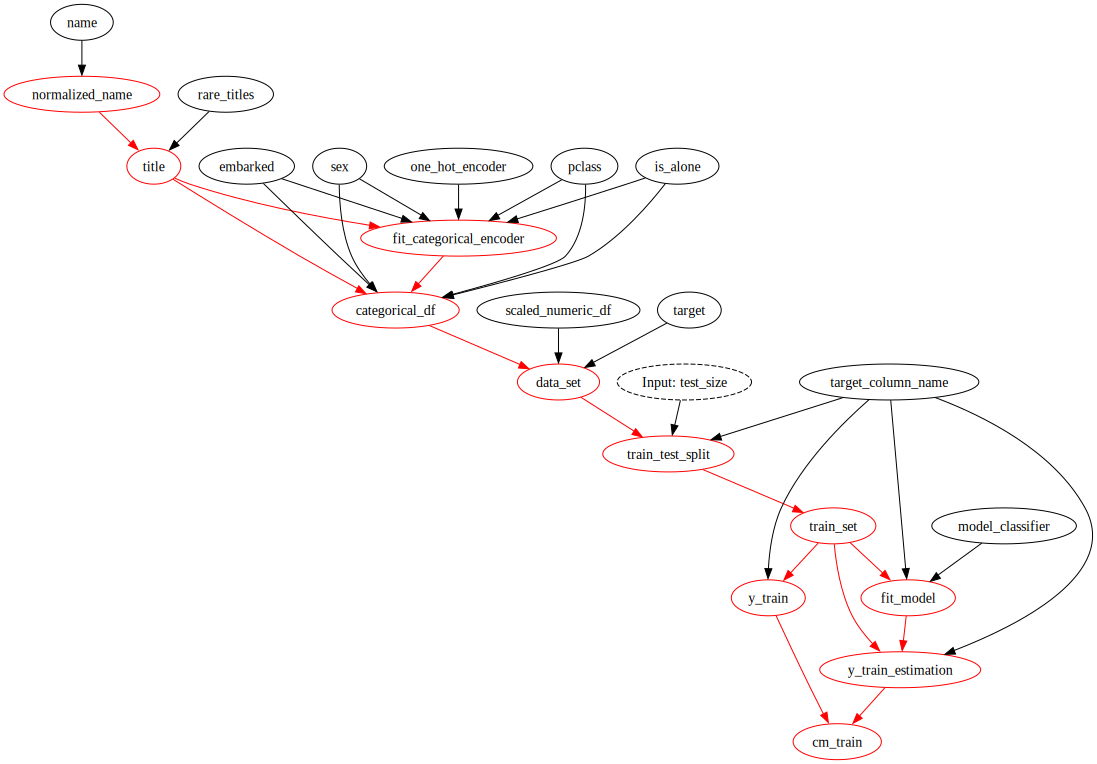

In [54]:
dw_dr.visualize_path_between("normalized_name", "cm_train")

# Let's talk tasks & Hamilton DAG composability

The above examples have all be running with the assumption that you want to run everything head to toe.

However Hamilton provides you the flexibility to end computation whereever you want it in the graph. That way you can have a large dataflow defined, and then only compute bits of it. This is useful if you cannot do everything in memory/on the box, and need to split work up.

Let's see how this would be done. A common use case here is for example splitting up data & feature processing from model fitting into two separate airflow tasks.

## Splitting up computation into two steps

In [55]:
# step 1 compute features
config = {"model_to_use": "create_new", "loader": "openml"}  # assumes we are creating a new model 
dr = (
        driver.Builder()
        .with_modules(data_loader, features, ml_pipeline)
        .with_config(config)
        .build()
    )
# materialize the two datasets
materialized_data, _ = dr.materialize(
  to.parquet(
        id="data_set_parquet",
        path="data_set_v1.parquet",
        dependencies=["data_set"],
  ),
  to.parquet(
        id="inference_set_parquet",
        path="inference_set_v1.parquet",
        dependencies=["inference_set"],
  ),
)
materialized_data

/Users/stefankrawczyk/.pyenv/versions/3.9.13/envs/temp-py39/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


{'data_set_parquet': {'size': 31109,
  'path': 'data_set_v1.parquet',
  'last_modified': 1696567541.6905515,
  'timestamp': 1696592741.690699},
 'inference_set_parquet': {'size': 30226,
  'path': 'inference_set_v1.parquet',
  'last_modified': 1696567541.6958346,
  'timestamp': 1696592741.695972}}

In [56]:
# step 2 fit the model --
# we need to pass in the data -- we don't want to start from the beginning again
d_set = pd.read_parquet("data_set_v1.parquet")
i_set = pd.read_parquet("inference_set_v1.parquet")

materialized_data, extra_outputs = dr.materialize(
    to.pickle(
      id="fit_model_pickle",
      path="fit_model.pkl",
      dependencies=["fit_model"]
    ),
    additional_vars=["y_test_accuracy", "model_predict"],
    inputs={"random_state": 1, "test_size": 0.2},
    overrides={"data_set": d_set, "inference_set": i_set}  # <-- we provided values to override
)
print(materialized_data)
print(extra_outputs)

{'fit_model_pickle': {'size': 1201, 'path': 'fit_model.pkl', 'last_modified': 1696567541.7529376, 'timestamp': 1696592741.753073}}
{'y_test_accuracy': 0.7824427480916031, 'model_predict': array(['1', '1', '1', ..., '0', '0', '0'], dtype=object)}


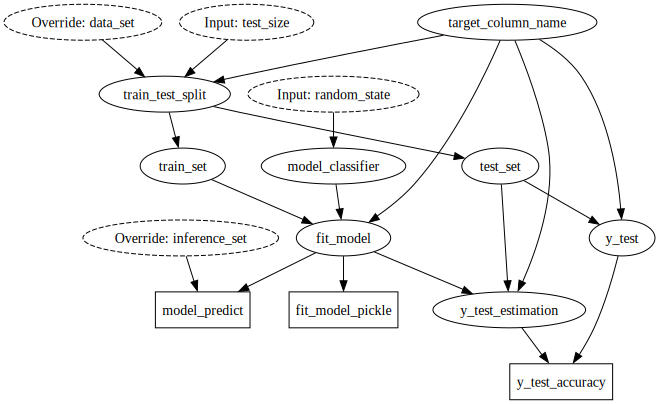

In [57]:
dr.visualize_materialization(
    to.pickle(
      id="fit_model_pickle",
      path="fit_model.pkl",
      dependencies=["fit_model"]
    ),
    additional_vars=["y_test_accuracy", "model_predict"],
    inputs={"random_state": 1, "test_size": 0.2},
    overrides={"data_set": d_set, "inference_set": i_set}  # <-- we provided values to override
)

# Add DAGWorks

In [58]:
materialized_data, extra_outputs = dw_dr.materialize(
    to.pickle(
      id="fit_model_pickle",
      path="fit_model.pkl",
      dependencies=["fit_model"]
    ),
    additional_vars=["y_test_accuracy", "model_predict"],
    inputs={"random_state": 1, "test_size": 0.2},
    overrides={"data_set": d_set, "inference_set": i_set}  # <-- we provided values to override
)
# this will show what was or was not executed pretty clearly.


Captured execution run. Results can be found at https://app.dagworks.io/dashboard/project/3/runs/1117



# Reusing the fit model

Overrides are a valid way to inject values into the DAG that were previously computed (e.g. you can roll your own caching this way...).
But we can also just have a direct path in the DAG that is configuration based that can enshrien the appropriate code.

Recall this:

```
@config.when(model_to_use="create_new")
def fit_model__create_new(
    model_classifier: base.ClassifierMixin, train_set: pd.DataFrame, target_column_name: str
) -> base.ClassifierMixin:
    """Fits a new model.

    :param model_classifier:
    :param train_set:
    :return:
    """
    feature_cols = [c for c in train_set.columns if c != target_column_name]
    model_classifier.fit(train_set[feature_cols], train_set[target_column_name])
    return model_classifier


@config.when(model_to_use="use_existing")
def fit_model__use_existing(model_path: str) -> base.ClassifierMixin:
    with open(model_path, "rb") as f:
        return pickle.load(f)
```

In [59]:
dw_dr = dw_driver.Driver(
   {"model_to_use": "use_existing"},
   data_loader, features, ml_pipeline,
   project_id=DAGWORKS_PROJECT_ID,
   api_key=DAGWORKS_API_KEY,
   username=DAGWORKS_PROJECT_EMAIL,
   dag_name="titanic-data-loading-features-ml-pipeline-predict",
   tags={"env": "local", "where": "notebook"},
   adapter=base.DefaultAdapter()
)

materialized_data, extra_outputs = dw_dr.materialize(
    additional_vars=["model_predict"],
    overrides={"inference_set": i_set},
    inputs={"model_path": "fit_model.pkl"}
)
extra_outputs


Captured execution run. Results can be found at https://app.dagworks.io/dashboard/project/3/runs/1118



{'model_predict': array(['1', '1', '1', ..., '0', '0', '0'], dtype=object)}

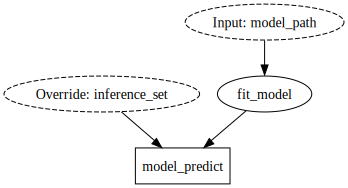

In [60]:
# Let's see what the execution plan was:
dw_dr.visualize_materialization(
    additional_vars=["model_predict"],
    overrides={"inference_set": i_set},
    inputs={"model_path": "fit_model.pkl"}
)